In [ ]:
! wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
! tar -zxvf 101_ObjectCategories.tar.gz

In [67]:
import numpy as np

In [94]:
from os import listdir
from os.path import isfile, join

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [155]:
LABELS = set(["Faces", "Leopards", "Motorbikes", "airplanes"])

imagePaths = list(paths.list_images("101_ObjectCategories"))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
 
    if label not in LABELS:
        continue
 
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (96, 96))
 
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
    
print("image loaded")

image loaded


(96, 96, 3)


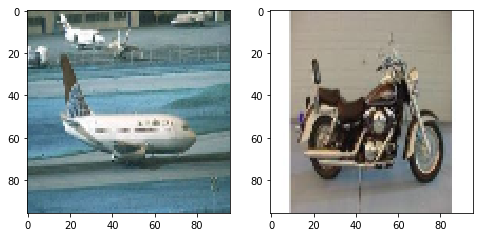

In [160]:
print(data[0].shape)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(data[123])
plt.subplot(1,2,2)
plt.imshow(data[1234])

In [161]:
data = np.array(data) / 255

In [162]:
data.shape

(2233, 96, 96, 3)

In [147]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

In [125]:
binarizer = LabelBinarizer()

In [131]:
labels = binarizer.fit_transform(labels)

In [134]:
from sklearn.model_selection import train_test_split

In [135]:
x_train,x_test,y_train,y_test = train_test_split(data,labels,test_size=0.3)

In [173]:
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Dropout,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

In [174]:
model = Sequential()
model.add(Conv2D(32,(3,3),padding="same",activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(128,(3,3),padding="same",activation="relu"))
model.add(MaxPool2D())

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [175]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model.fit(x=x_train,y=y_train,batch_size=64,epochs=25,validation_data=(x_test,y_test),callbacks=[earlyStopping,mcp_save,reduce_lr_loss])

Train on 1563 samples, validate on 670 samples
Epoch 1/10
1563/1563 [==============================] - 20s 13ms/sample - loss: 0.4804 - acc: 0.8157 - val_loss: 0.0709 - val_acc: 0.9761
Epoch 2/10
1563/1563 [==============================] - 19s 12ms/sample - loss: 0.1213 - acc: 0.9661 - val_loss: 0.1024 - val_acc: 0.9716
Epoch 3/10
1563/1563 [==============================] - 20s 13ms/sample - loss: 0.0576 - acc: 0.9814 - val_loss: 0.0356 - val_acc: 0.9866
Epoch 4/10
1563/1563 [==============================] - 19s 12ms/sample - loss: 0.0201 - acc: 0.9942 - val_loss: 0.0140 - val_acc: 0.9970
Epoch 5/10
1563/1563 [==============================] - 19s 12ms/sample - loss: 0.0336 - acc: 0.9878 - val_loss: 0.0390 - val_acc: 0.9851
Epoch 6/10
1563/1563 [==============================] - 19s 12ms/sample - loss: 0.0258 - acc: 0.9936 - val_loss: 0.0340 - val_acc: 0.9910
Epoch 7/10
1563/1563 [==============================] - 18s 12ms/sample - loss: 0.0142 - acc: 0.9930 - val_loss: 0.0193 - val

In [176]:
model.evaluate(x=x_test,y=y_test)

670/670 [==============================] - 1s 2ms/sample - loss: 0.0204 - acc: 0.9955 0s - loss: 0.0389 - 


[0.020374750980365425, 0.9955224]

In [177]:
pred = [p.argmax() for p in model.predict(x_test)]

In [178]:
y_test_oneclass = [p.argmax() for p in y_test]

print(confusion_matrix(y_test_oneclass,pred))

print(classification_report(y_test_oneclass,pred))

[[144   0   0   0]
 [  0  64   0   0]
 [  0   0 227   0]
 [  0   0   3 232]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00        64
           2       0.99      1.00      0.99       227
           3       1.00      0.99      0.99       235

   micro avg       1.00      1.00      1.00       670
   macro avg       1.00      1.00      1.00       670
weighted avg       1.00      1.00      1.00       670

